In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.linear_model import LinearRegression
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import LinearSystemInput
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms.classical import ExactLSsolver
from pylab import * 
import seaborn as sns

In [2]:
def fidelity(hhl, ref):
    solution_hhl_normed = hhl / np.linalg.norm(hhl)
    solution_ref_normed = ref / np.linalg.norm(ref)
    fidelity = state_fidelity(solution_hhl_normed, solution_ref_normed)
    print("fidelity %f" % fidelity)

In [3]:
params = {
    'problem': {'name': 'linear_system'},
    'algorithm': {'name': 'HHL'},
    'eigs': {'expansion_mode': 'suzuki',
             'expansion_order': 2,
             'name': 'EigsQPE',
             'num_ancillae': 3,
             'num_time_slices': 50 },
    'reciprocal': { 'name': 'Lookup'},
    'backend': { 'provider': 'qiskit.BasicAer',
                 'name': 'statevector_simulator'}
}

In [4]:
# bi = np.random.binomial(n=100, p=0.5, size=10000)
# plt.hist(bi, bins=20, normed=True);

In [5]:
''' Linear Regression with 2 variables - Create dataset'''

N = 100
m_1 = 0; m_2 = 2
s_1 = s_2 = 1

m_e = 0; s_e = 1

# Generate independent variables
x1 = np.random.normal( m_1 , s_1, N)
x2 = np.random.normal( m_1 , s_2, N)

In [6]:
# Coefficients
beta_0 = 0; beta_1 = 1; beta_2 = 2

# Dependent variable
y = beta_0 + beta_1*x1 + beta_2*x2 + np.random.normal(m_e , s_e, N)

# Design matrix
X = pd.concat( [pd.Series(x1), pd.Series(x2)], axis = 1 )
XX = np.round(X.values.transpose().dot(X.values), 2)
print( XX)
print('The condition number is: ', np.round( max(np.linalg.svd(XX)[1])/min(np.linalg.svd(XX)[1]), 2) )
print('The correlation between x1 and x2 is: ', np.round( np.corrcoef(x1, x2)[0,1], 3 ) )

[[ 91.47 -34.03]
 [-34.03  96.65]]
The condition number is:  2.14
The correlation between x1 and x2 is:  -0.337


In [7]:
# Fitting regression
reg = LinearRegression().fit(X, y)
reg.score(X, y)

# Fitting regression by hand
XX_inv = np.linalg.inv( X.values.transpose().dot(X.values) )
print( 'XX_inv is \n', XX_inv)
XY = X.values.transpose().dot(y)
# XY = [1, 5 ]

print('The regression coefficients are:', np.round( reg.coef_, 2))
print('The regression coefficients computing by hand are:', np.round( XX_inv.dot(XY), 2))
print( 'R squared =', np.round( reg.score(X, y), 2 ), '\n\n' )

XX_inv is 
 [[0.01258008 0.00442956]
 [0.00442956 0.01190578]]
The regression coefficients are: [1.19 2.11]
The regression coefficients computing by hand are: [1.2  2.08]
R squared = 0.78 




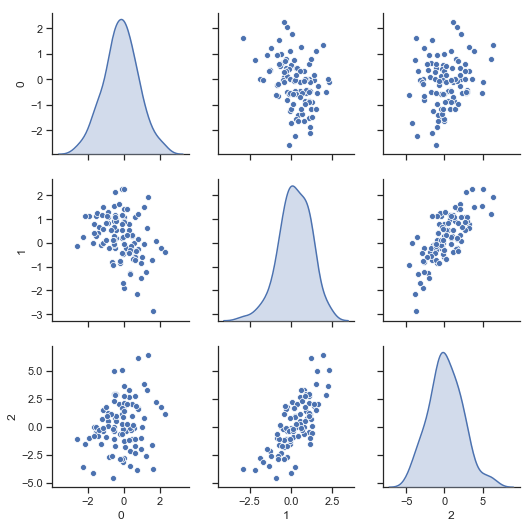

In [8]:
# Scatter plot matrix

sns.set(style="ticks")
df = pd.concat( [pd.Series(x1), pd.Series(x2), pd.Series(y)], axis = 1 )
sns.pairplot(df, diag_kind="kde") #, hue="species")

In [9]:
matrix = XX.tolist() ; print( 'Matrix XX \n', matrix )# [[2, 0], [0, 1]]
vector = XY.astype(int).tolist() ; print( '\n Vector XY \n', vector ) # [1, 4]

np.linalg.inv( matrix ).dot( vector )
print('The Pearson coefficient between x1 and x2 is \n: ', np.round( np.corrcoef(x1, x2)[0,1], 3 ) )


Matrix XX 
 [[91.47, -34.03], [-34.03, 96.65]]

 Vector XY 
 [39, 159]
The Pearson coefficient between x1 and x2 is 
:  -0.337


In [10]:
'''Quantum algorithm for linear regression (design matrix 2x2)'''

params['input'] = {
    'name': 'LinearSystemInput',
    'matrix': matrix,
    'vector': vector }


result = run_algorithm(params)
print("solution ", np.round(result['solution'], 5))

result_ref = ExactLSsolver(matrix, vector).run()
print("classical solution ", np.round(result_ref['solution'], 5))

print("probability %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

C:\Users\anton\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:547: DeprecationWarning: IBMQ.backends() is being deprecated. Please use IBMQ.get_provider() to retrieve a provider and AccountProvider.backends() to find its backends.
  DeprecationWarning)
C:\Users\anton\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:547: DeprecationWarning: IBMQ.backends() is being deprecated. Please use IBMQ.get_provider() to retrieve a provider and AccountProvider.backends() to find its backends.
  DeprecationWarning)


solution  [1.23886-0.j 2.07105-0.j]
classical solution  [1.19493 2.06584]
probability 0.083937
fidelity 0.999785


In [26]:
'''Quantum Ridge regression - ill-conditioned '''

m_e = 0; s_e = 1
alpha = 2

# Generate independent variables
x1 = np.random.normal( m_1 , s_1, N)
x2 = x1 * alpha + np.random.normal( m_e , 0.1, N)

y = beta_0 + beta_1*x1 + np.random.normal(m_e , s_e, N) # + beta_2*x2

# Design matrix
X = pd.concat( [pd.Series(x1), pd.Series(x2)], axis = 1 )
XX = np.round(X.values.transpose().dot(X.values), 2)
print( XX)
print('The condition number is: ', np.round( max(np.linalg.svd(XX)[1])/min(np.linalg.svd(XX)[1]), 2) )
print('The correlation between x1 and x2 is: ', np.round( np.corrcoef(x1, x2)[0,1], 3 ) )


[[ 94.3  188.35]
 [188.35 377.06]]
The condition number is:  2739.76
The correlation between x1 and x2 is:  0.999


In [27]:
# Fitting regression
reg = LinearRegression().fit(X, y)
reg.score(X, y)

# Fitting regression by hand
XX_inv = np.linalg.inv( X.values.transpose().dot(X.values) )
print( 'XX_inv is \n', XX_inv)
XY = X.values.transpose().dot(y)
# XY = [1, 5 ]

print('The regression coefficients are:', np.round( reg.coef_, 2))
print('The regression coefficients computing by hand are:', np.round( XX_inv.dot(XY), 2))
print( 'R squared =', np.round( reg.score(X, y), 2 ), '\n\n' )

XX_inv is 
 [[ 4.67595961 -2.33581072]
 [-2.33581072  1.16947394]]
The regression coefficients are: [-0.52  0.84]
The regression coefficients computing by hand are: [-0.53  0.84]
R squared = 0.58 




In [28]:
matrix = XX.tolist() ; print( 'Matrix XX \n', matrix )# [[2, 0], [0, 1]]
vector = XY.astype(int).tolist() ; print( '\n Vector XY \n', vector ) # [1, 4]

np.linalg.inv( matrix ).dot( vector )
print('The Pearson coefficient between x1 and x2 is \n: ', np.round( np.corrcoef(x1, x2)[0,1], 3 ) )

Matrix XX 
 [[94.3, 188.35], [188.35, 377.06]]

 Vector XY 
 [109, 219]
The Pearson coefficient between x1 and x2 is 
:  0.999


In [29]:
'''Quantum algorithm for linear regression (design matrix 2x2)'''

params['input'] = {
    'name': 'LinearSystemInput',
    'matrix': matrix,
    'vector': vector }


result = run_algorithm(params)
print("solution ", np.round(result['solution'], 5))

result_ref = ExactLSsolver(matrix, vector).run()
print("classical solution ", np.round(result_ref['solution'], 5))

print("probability %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

solution  [0.23209+0.j 0.46441-0.j]
classical solution  [-1.84006  1.49996]
probability 0.029854
fidelity 0.047827


In [30]:
'''Introduction of the penalty for ill-conditioned case'''

lambda_penalty = 500
matrix = (XX + np.diag(np.repeat(lambda_penalty, 2, axis=0))).tolist()
print( np.round(matrix) )

k = max(np.linalg.svd(matrix)[1])/min(np.linalg.svd(matrix)[1])
print( '(new) condition number = ', np.round( k, 2) )


print( np.linalg.inv( matrix ).dot( vector ) )
print('The Pearson coefficient between x1 and x2 is \n: ', np.round( np.corrcoef(x1, x2)[0,1], 3 ) )



[[594. 188.]
 [188. 877.]]
(new) condition number =  1.94
[0.11188812 0.22566971]
The Pearson coefficient between x1 and x2 is 
:  0.999


In [24]:
'''Quantum algorithm for linear regression (design matrix 2x2)'''

params['input'] = {
    'name': 'LinearSystemInput',
    'matrix': matrix,
    'vector': vector }


result = run_algorithm(params)
print("solution ", np.round(result['solution'], 5))

result_ref = ExactLSsolver(matrix, vector).run()
print("classical solution ", np.round(result_ref['solution'], 5))

print("probability %f" % result['probability_result'])
fidelity(result['solution'], result_ref['solution'])

solution  [0.11944-0.j 0.27928-0.j]
classical solution  [0.11843 0.27976]
probability 0.032661
fidelity 0.999986


ValueError: Argument Z must be 2-dimensional.

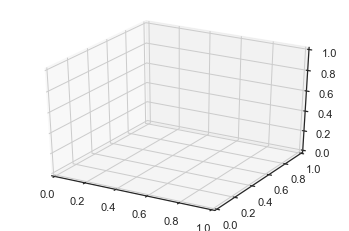

In [48]:
# 3D plot 
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = plt.axes(projection='3d')
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
# zline = np.linspace(0, 15, 1000)
# xline = np.sin(zline)
# yline = np.cos(zline)
#ax.plot3D(xline, yline, zline, 'gray')

# Data for a three-dimensional line
zline = beta_0 + beta_1*x1 + beta_2*x2
xline = x1
yline = x2
# ax.plot3D(xline, yline, zline, 'gray')



# Data for three-dimensional scattered points
zdata = beta_0 + beta_1*x1 + beta_2*x2
xdata = x1
ydata = x2
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

plt3d = plt.figure().gca(projection='3d')
plt3d.plot_surface(zline, yline, xline)